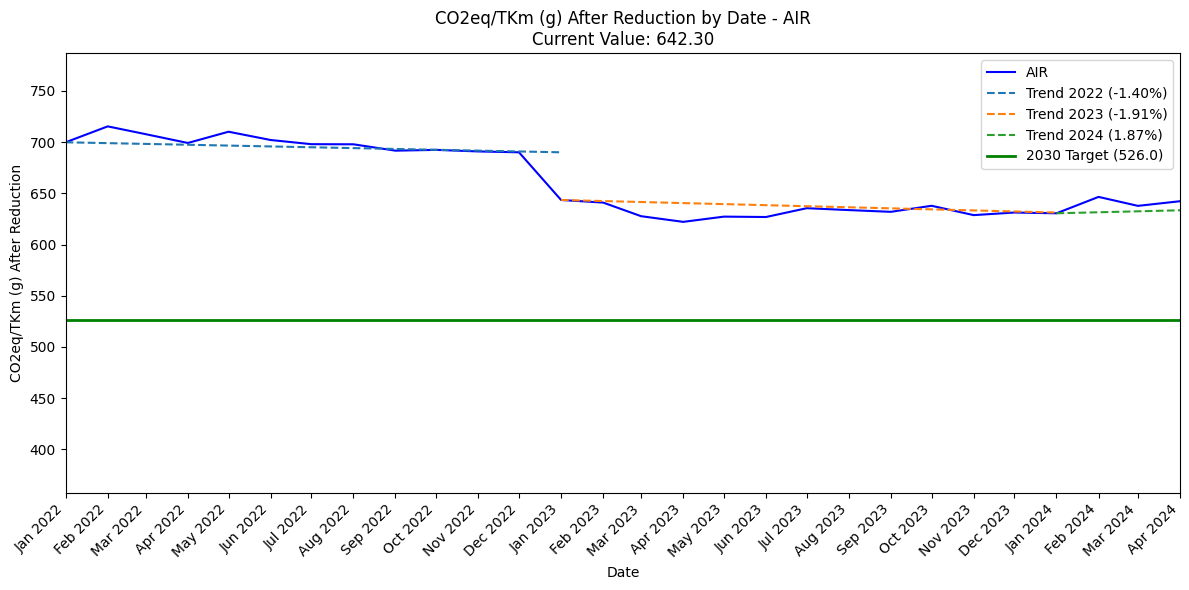

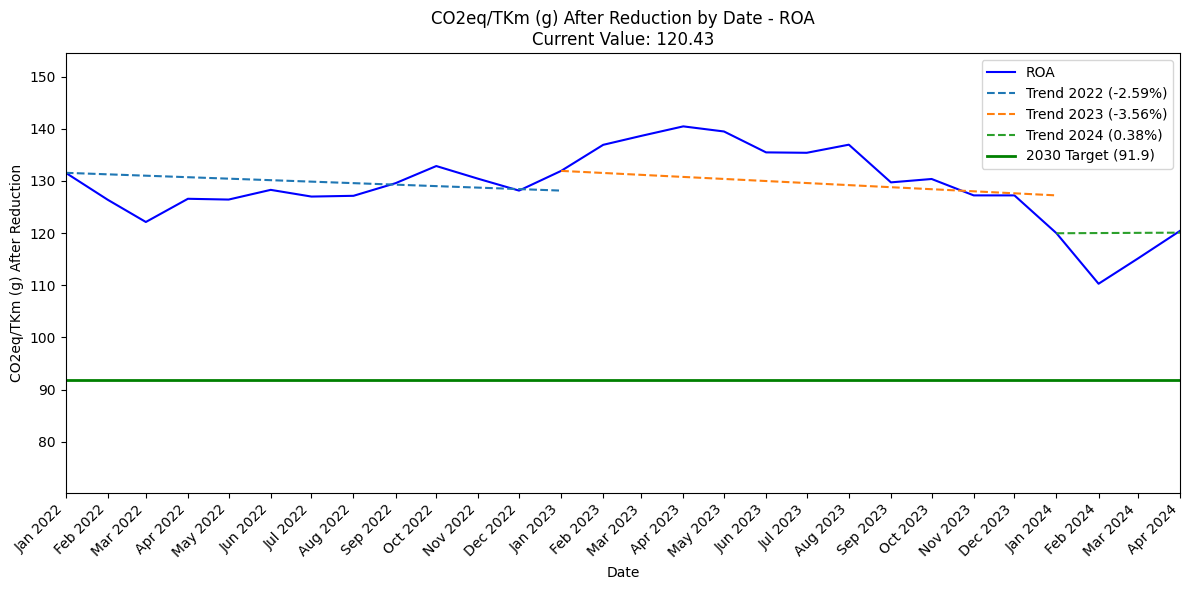

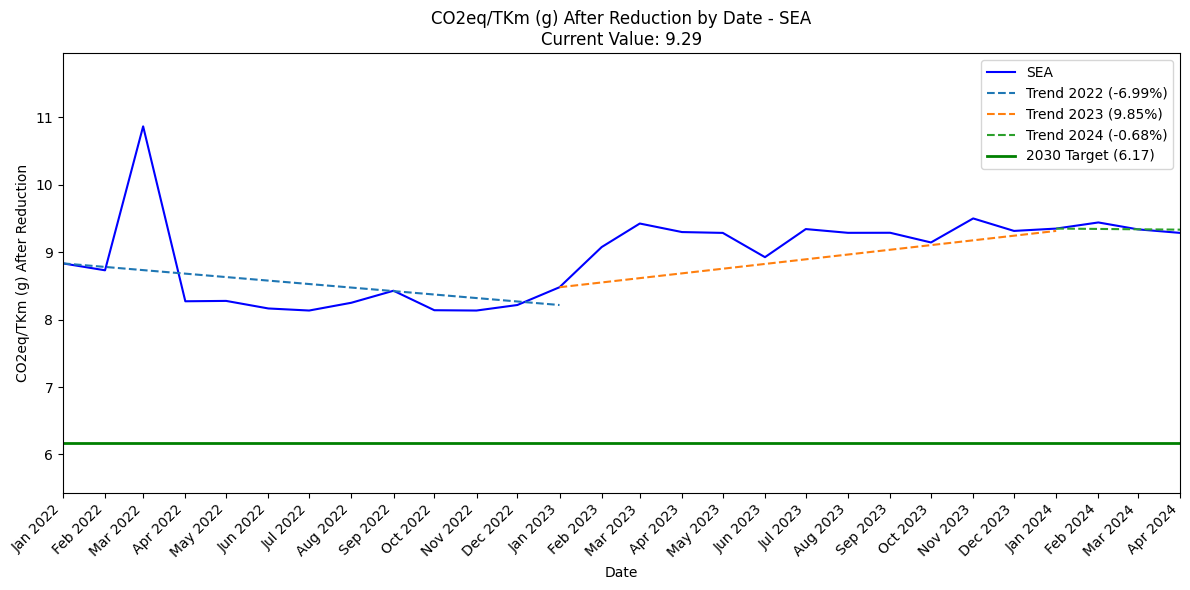

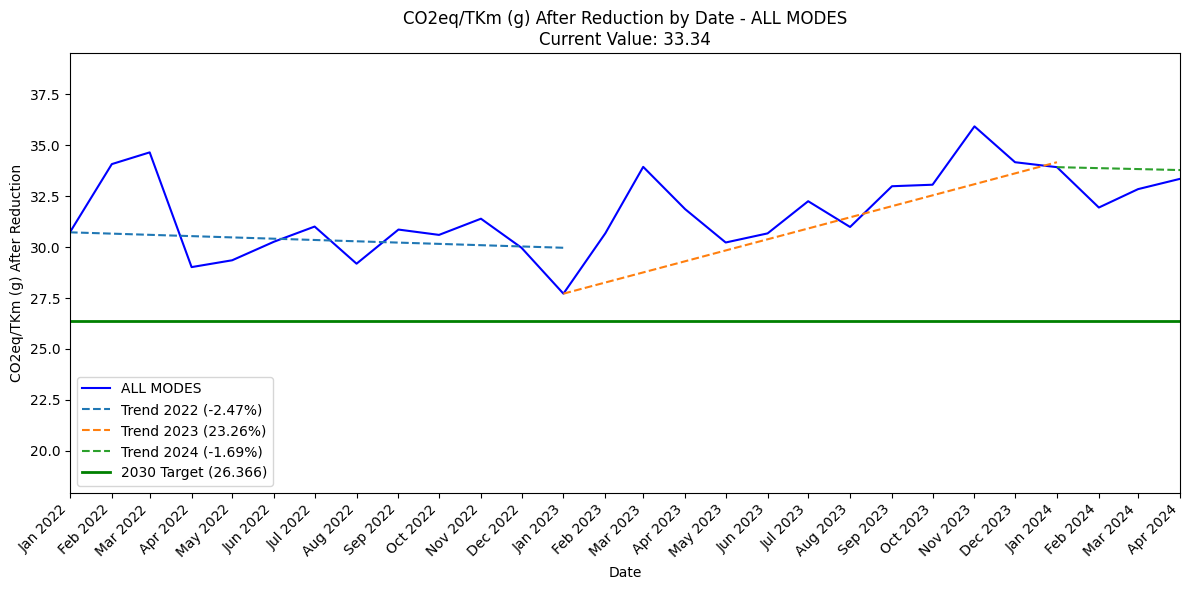

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

# Read the Excel file into a pandas DataFrame
df = pd.read_excel('100f177e-f178-43f9-8c65-5f0716ffd1bc.xlsx')

# Convert 'Service Completion Month' and 'Service Completion Year' to datetime
df['Date'] = pd.to_datetime(df['Service Completion Month'].str[:3] + ' ' + df['Service Completion Year'].astype(str), format='%b %Y')

# Define the transport modes and their corresponding 2030 targets
transport_modes = ['AIR', 'ROA', 'SEA', 'ALL MODES']
targets = {'AIR': 526.0, 'ROA': 91.90, 'SEA': 6.17, 'ALL MODES': 26.366}

for mode in transport_modes:
    # Filter the data for the current transport mode
    mode_data = df[df['Leg Transport Mode'] == mode]
    
    # Sort the data by date
    mode_data = mode_data.sort_values('Date')
    
    # Create a figure and subplot for the current transport mode
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the line for the current transport mode
    ax.plot(mode_data['Date'], mode_data['CO2eq/TKm (g) After Reduction'], label=mode, color=(0, 0, 1))
    
    # Calculate the maximum y-value for the current transport mode
    max_value = mode_data['CO2eq/TKm (g) After Reduction'].max()
    
    # Set the x-axis limits to start from January 2022
    start_date = datetime(2022, 1, 1)
    end_date = mode_data['Date'].max()
    ax.set_xlim(left=start_date, right=end_date)
    
    # Generate x-axis ticks for each month
    months = pd.date_range(start=start_date, end=end_date, freq='MS')
    ax.set_xticks(months)
    
    # Set the x-axis label and format
    ax.set_xlabel('Date')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    
    # Set the y-axis label
    ax.set_ylabel('CO2eq/TKm (g) After Reduction')
    
    # Set the y-axis limits to 50% of the maximum value and add some space on top
    ax.set_ylim(bottom=max_value * 0.5, top=max_value * 1.1)
    
    # Get the unique years in the data
    years = mode_data['Date'].dt.year.unique()
    
    # Plot the trend line for each year and calculate the percentage change
    for year in years:
        # Filter the data for the current year
        year_data = mode_data[(mode_data['Date'].dt.year == year)]
        
        # Get the start and end dates for the trend line
        start_date = datetime(year, 1, 1)
        end_date = datetime(year + 1, 1, 1)
        
        # Get the first and last values for the trend line
        start_value = year_data['CO2eq/TKm (g) After Reduction'].iloc[0]
        end_value = year_data['CO2eq/TKm (g) After Reduction'].iloc[-1]
        
        # Calculate the percentage change
        percentage_change = (end_value - start_value) / start_value * 100
        
        # Plot the trend line with the percentage change
        ax.plot([start_date, end_date], [start_value, end_value], linestyle='--', label=f'Trend {year} ({percentage_change:.2f}%)')
    
    # Draw a horizontal line at the 2030 target
    ax.axhline(targets[mode], color='green', linestyle='-', linewidth=2, label=f'2030 Target ({targets[mode]})')
    
    # Get the current value
    current_value = mode_data['CO2eq/TKm (g) After Reduction'].iloc[-1]
    
    # Set the subplot title with the current value
    ax.set_title(f'CO2eq/TKm (g) After Reduction by Date - {mode}\nCurrent Value: {current_value:.2f}')
    
    # Add a legend
    ax.legend()
    
    # Rotate the x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Save the plot as an individual picture
    plt.tight_layout()
    plt.savefig(f'{mode}.png')
    
    # Display the plot
    plt.show()

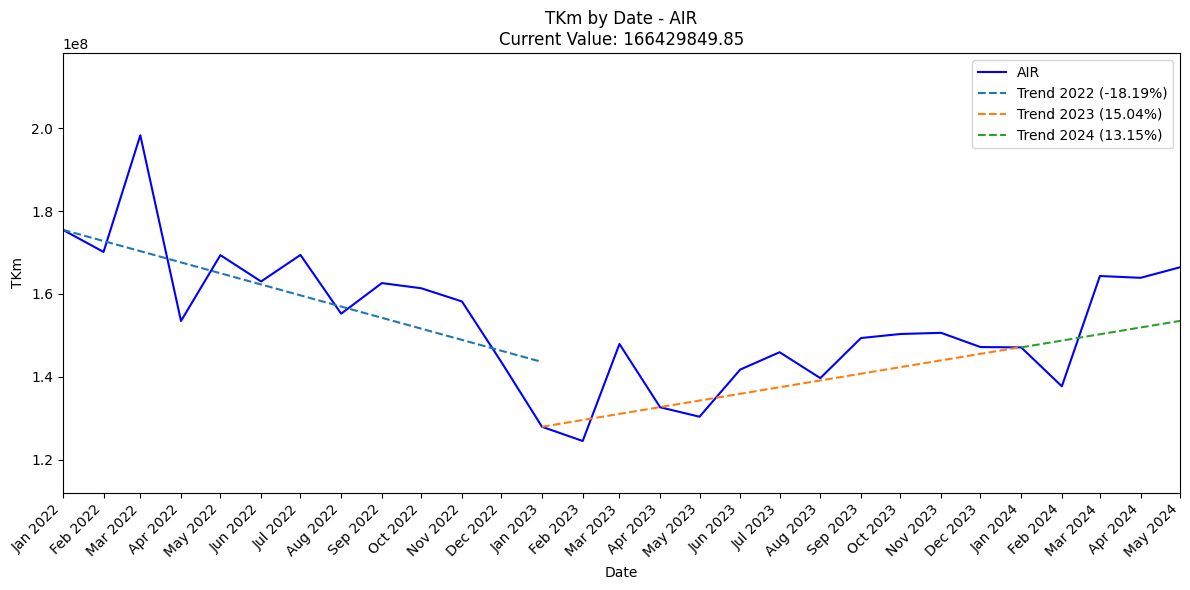

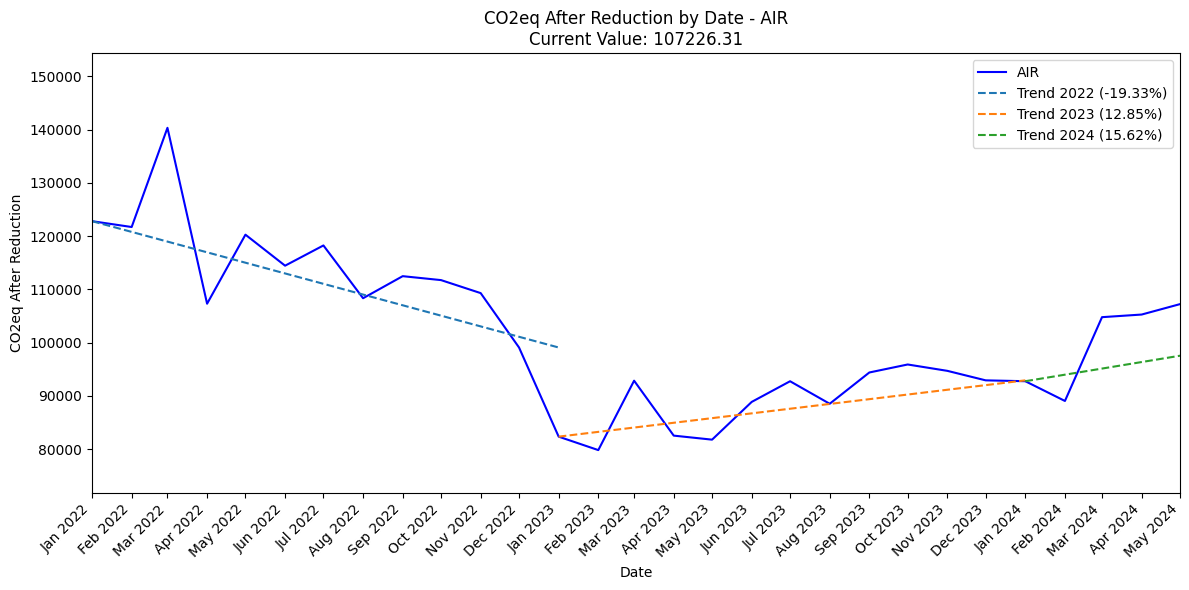

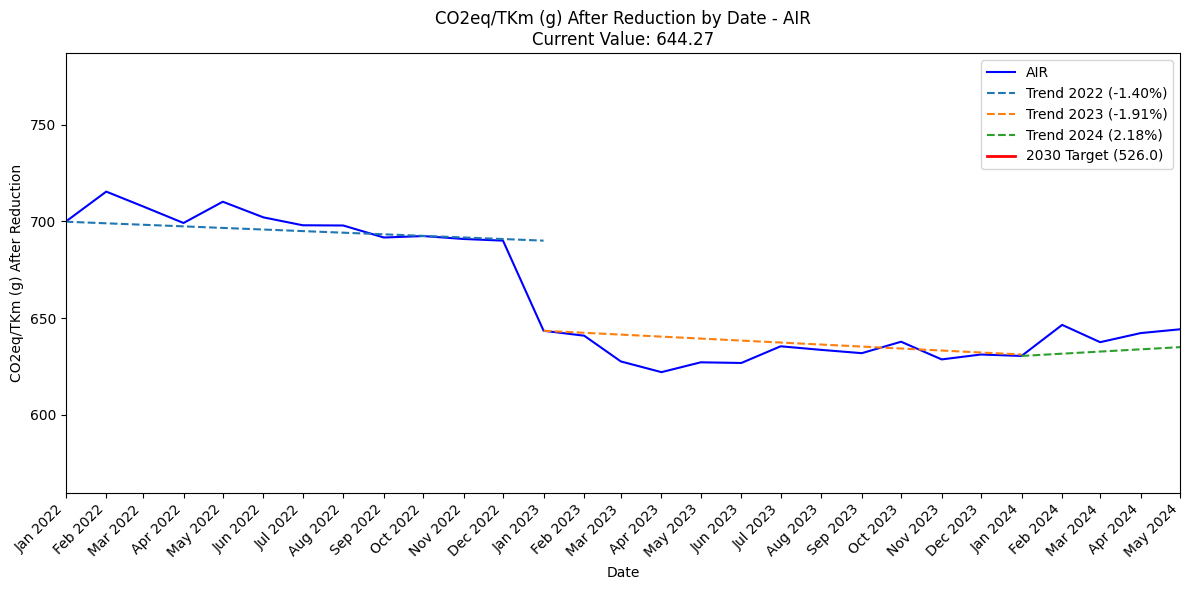

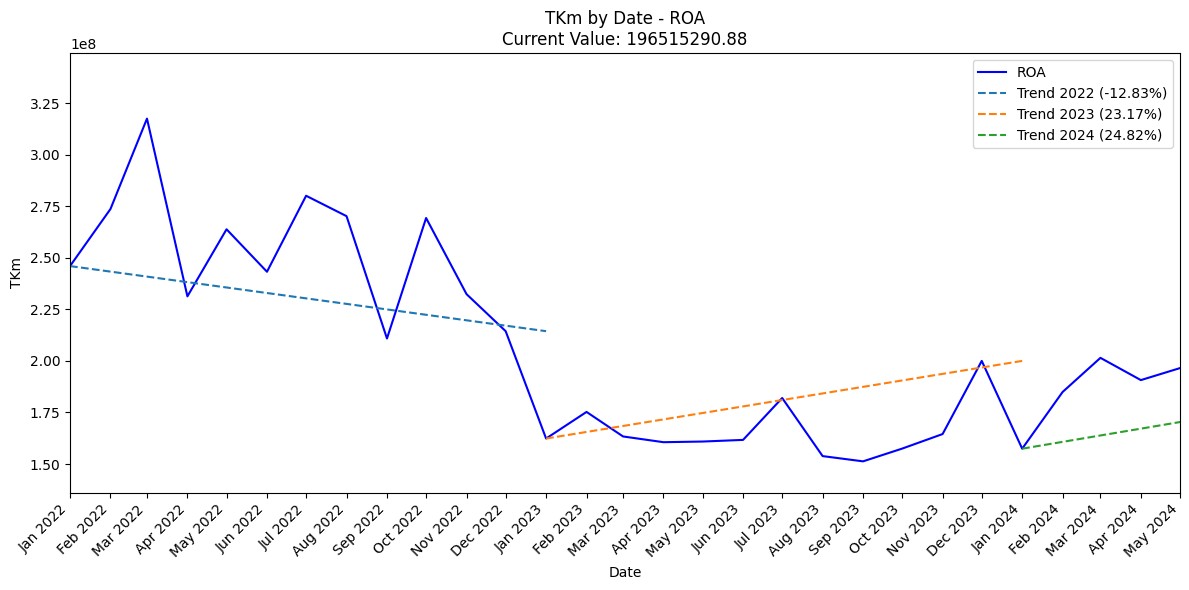

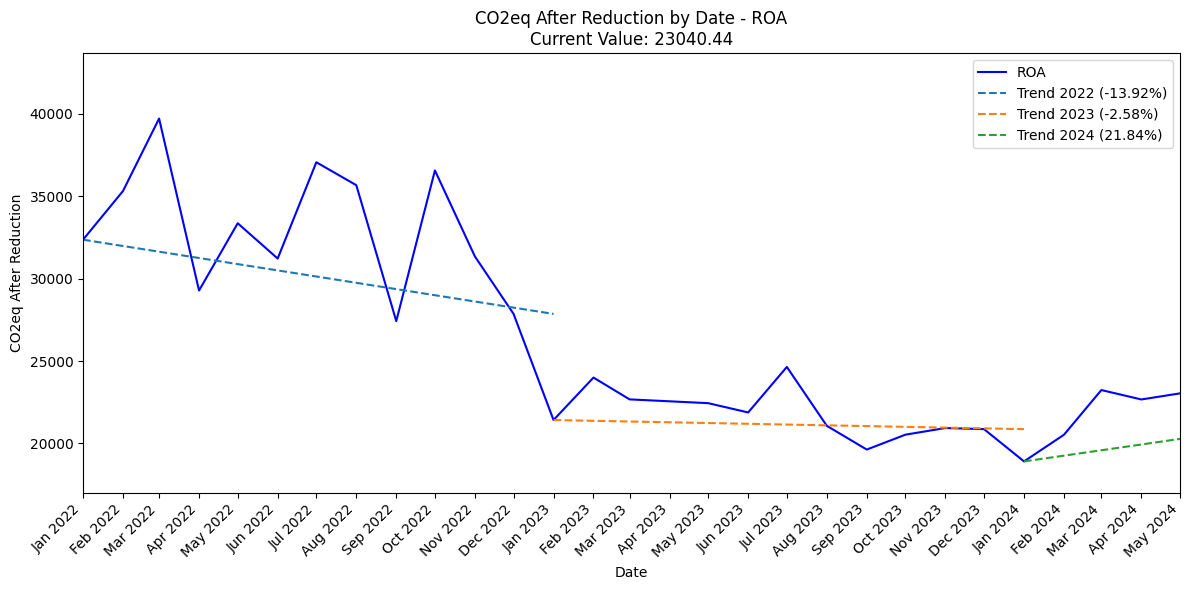

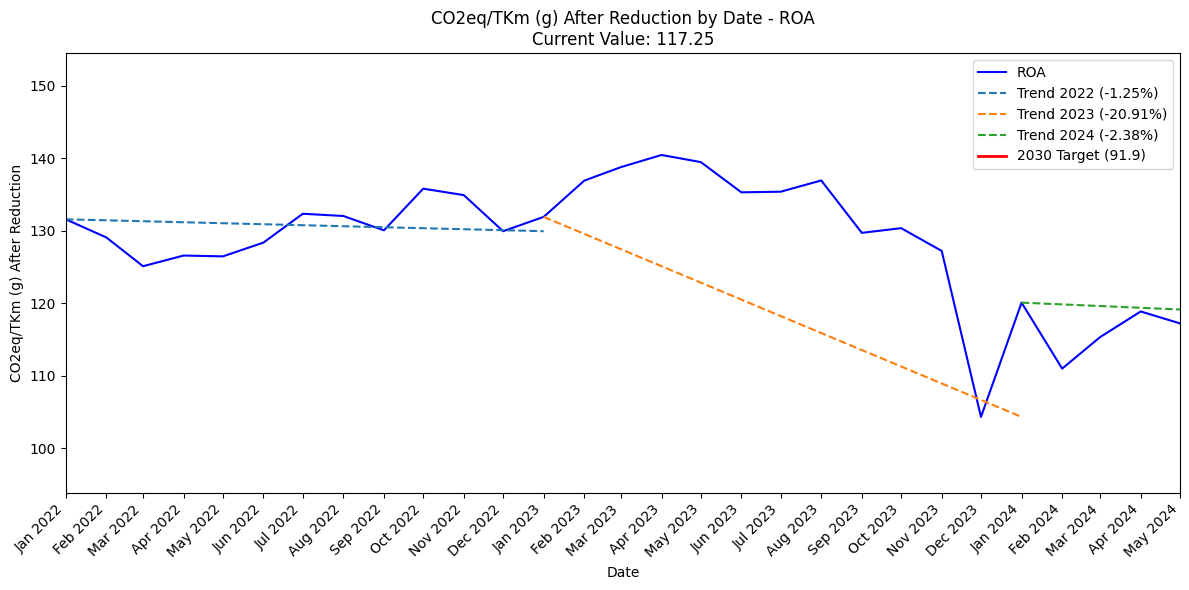

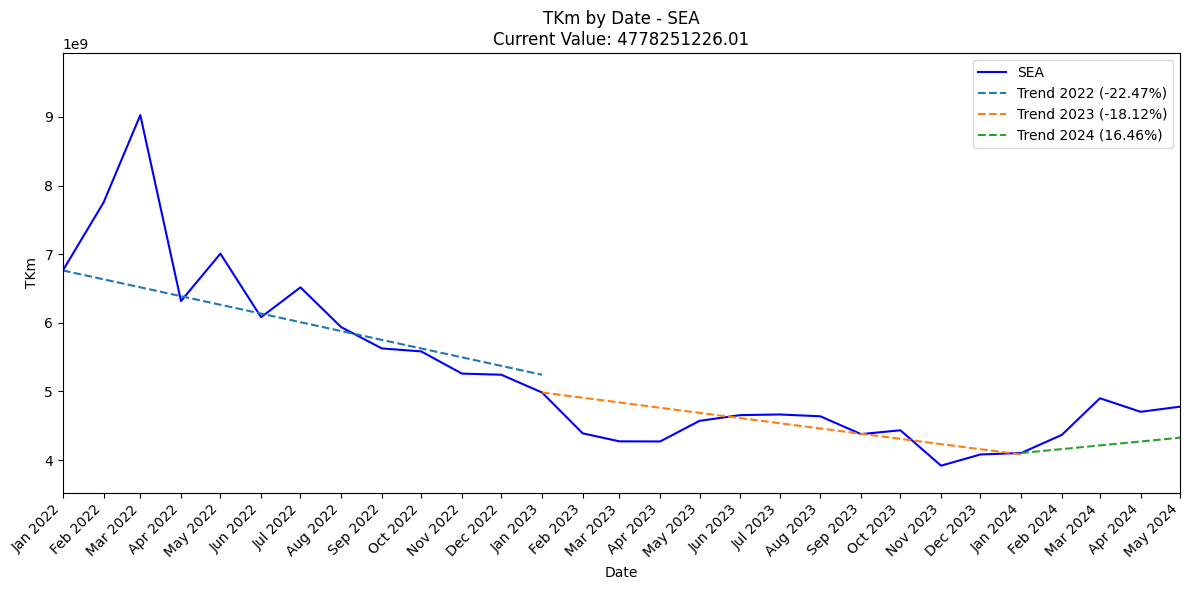

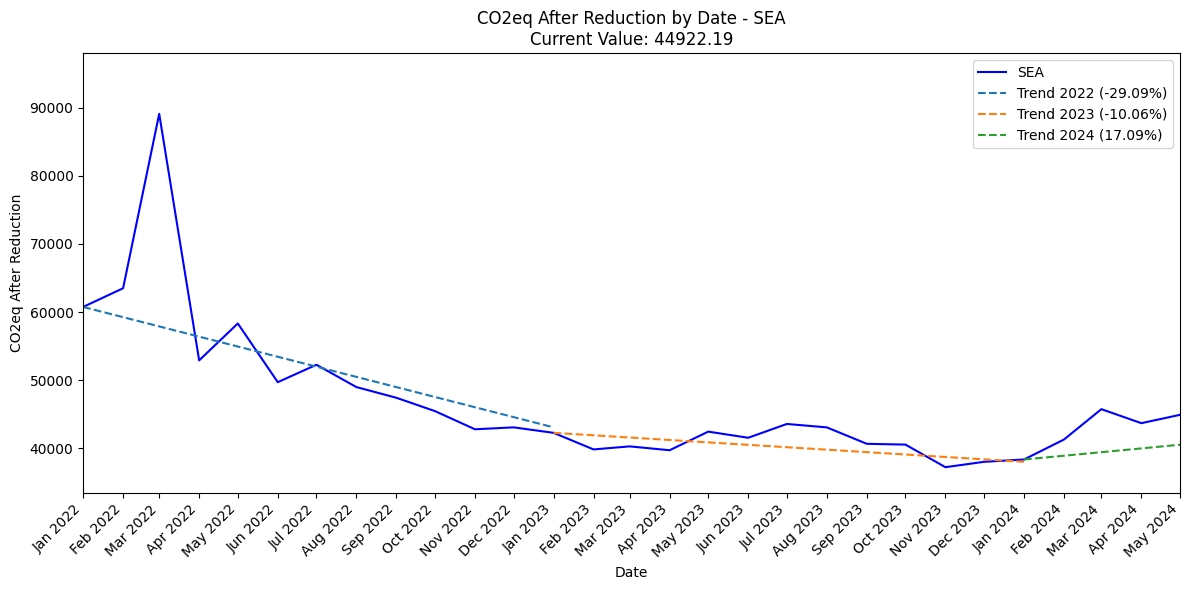

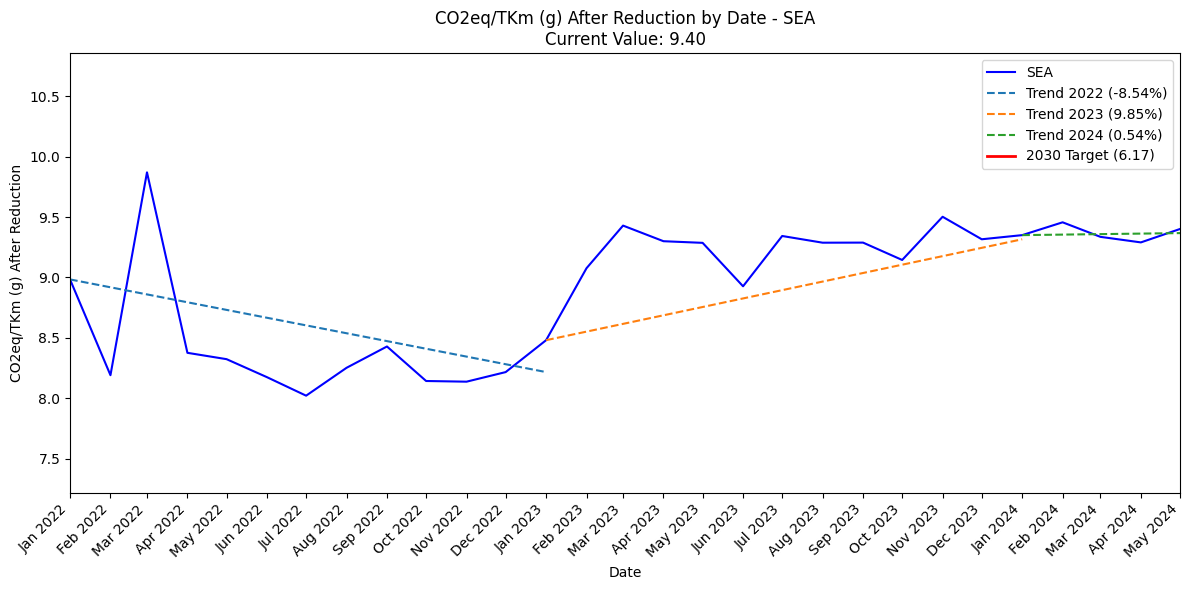

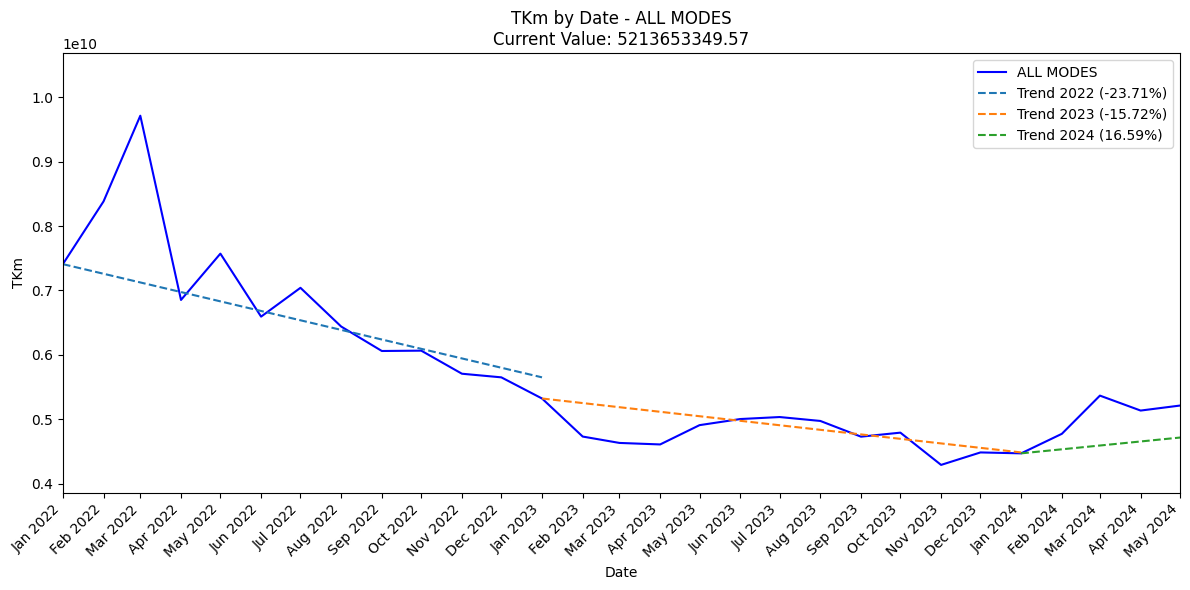

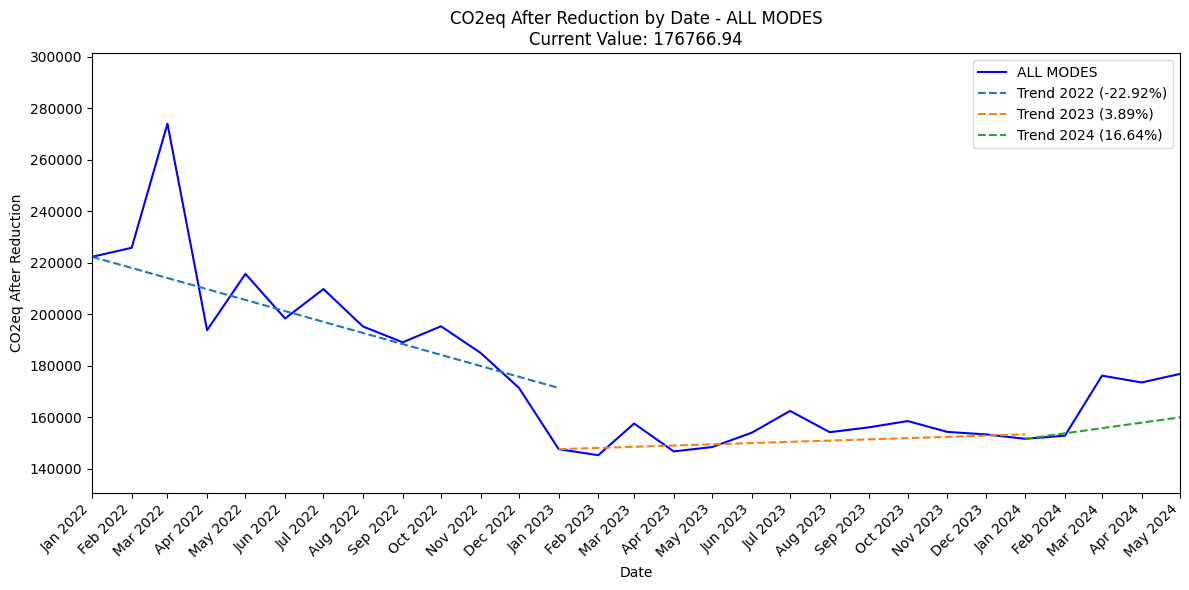

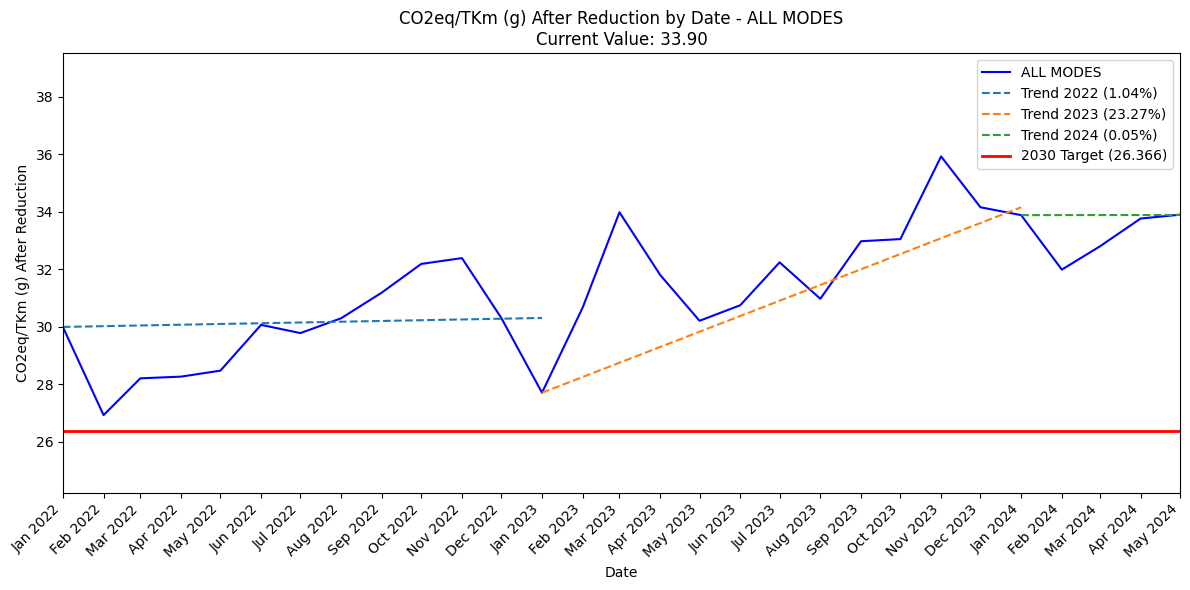

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

# Read the Excel file into a pandas DataFrame
df = pd.read_excel('inn.xlsx')

# Convert 'Service Completion Month' and 'Service Completion Year' to datetime
df['Date'] = pd.to_datetime(df['Service Completion Month'].str[:3] + ' ' + df['Service Completion Year'].astype(str), format='%b %Y')

# Define the transport modes and their corresponding 2030 targets
transport_modes = ['AIR', 'ROA', 'SEA', 'ALL MODES']
targets = {'AIR': 526.0, 'ROA': 91.90, 'SEA': 6.17, 'ALL MODES': 26.366}

# Define the columns to plot
columns_to_plot = ['TKm', 'CO2eq After Reduction', 'CO2eq/TKm (g) After Reduction']

# Add a row for 'ALL MODES'
numeric_columns = ['TKm', 'CO2eq (tonnes)', 'CO2eq After Reduction']
df_all_modes = df.groupby(['Service Completion Month', 'Service Completion Year'])[numeric_columns].sum().reset_index()
df_all_modes['Leg Transport Mode'] = 'ALL MODES'
df_all_modes['Date'] = pd.to_datetime(df_all_modes['Service Completion Month'].str[:3] + ' ' + df_all_modes['Service Completion Year'].astype(str), format='%b %Y')

# Calculate combined CO2eq/TKm (g) After Reduction for ALL MODES
df_all_modes['CO2eq/TKm (g) After Reduction'] = (df_all_modes['CO2eq After Reduction'] * 1e6) / df_all_modes['TKm']

# Combine the all modes data back to the original dataframe
df = pd.concat([df, df_all_modes], ignore_index=True)

for mode in transport_modes:
    # Filter the data for the current transport mode
    mode_data = df[df['Leg Transport Mode'] == mode]
    
    # Sort the data by date
    mode_data = mode_data.sort_values('Date')
    
    for column in columns_to_plot:
        # Create a figure and subplot for the current transport mode and column
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot the line for the current transport mode and column
        ax.plot(mode_data['Date'], mode_data[column], label=mode, color=(0, 0, 1))
        
        # Calculate the maximum y-value for the current transport mode and column
        max_value = mode_data[column].max()
        min_value = mode_data[column].min()
        
        # Set the x-axis limits to start from January 2022
        start_date = datetime(2022, 1, 1)
        end_date = mode_data['Date'].max()
        
        # Check if end_date is valid and adjust if necessary
        if pd.isna(end_date) or end_date < start_date:
            end_date = datetime.today()
        
        ax.set_xlim(left=start_date, right=end_date)
        
        # Generate x-axis ticks for each month
        months = pd.date_range(start=start_date, end=end_date, freq='MS')
        ax.set_xticks(months)
        
        # Set the x-axis label and format
        ax.set_xlabel('Date')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        
        # Set the y-axis label
        ax.set_ylabel(column)
        
        # Set the y-axis limits with padding to ensure visibility
        if pd.notna(max_value) and max_value > 0:
            ax.set_ylim(bottom=min_value * 0.9, top=max_value * 1.1)
        
        # Get the unique years in the data
        years = mode_data['Date'].dt.year.unique()
        
        # Plot the trend line for each year and calculate the percentage change
        for year in years:
            # Filter the data for the current year
            year_data = mode_data[(mode_data['Date'].dt.year == year)]
            
            # Check if year_data is empty
            if year_data.empty:
                continue
            
            # Get the start and end dates for the trend line
            start_date = datetime(year, 1, 1)
            end_date = datetime(year + 1, 1, 1)
            
            # Get the first and last values for the trend line
            start_value = year_data[column].iloc[0]
            end_value = year_data[column].iloc[-1]
            
            # Calculate the percentage change
            percentage_change = (end_value - start_value) / start_value * 100
            
            # Plot the trend line with the percentage change
            ax.plot([start_date, end_date], [start_value, end_value], linestyle='--', label=f'Trend {year} ({percentage_change:.2f}%)')
        
        # Draw a horizontal line at the 2030 target only for 'CO2eq/TKm (g) After Reduction'
        if column == 'CO2eq/TKm (g) After Reduction' and mode in targets:
            ax.axhline(targets[mode], color='red', linestyle='-', linewidth=2, label=f'2030 Target ({targets[mode]})')
        
        # Get the current value
        if not mode_data[column].empty:
            current_value = mode_data[column].iloc[-1]
            # Set the subplot title with the current value
            ax.set_title(f'{column} by Date - {mode}\nCurrent Value: {current_value:.2f}')
        else:
            ax.set_title(f'{column} by Date - {mode}\nNo data available')
        
        # Add a legend
        ax.legend()
        
        # Rotate the x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        # Replace '/' with '_' in the column name for the filename
        filename = f'{mode}_{column.replace("/", "_")}.png'
        
        # Save the plot as an individual picture
        plt.tight_layout()
        plt.savefig(filename)
        
        # Display the plot
        plt.show()


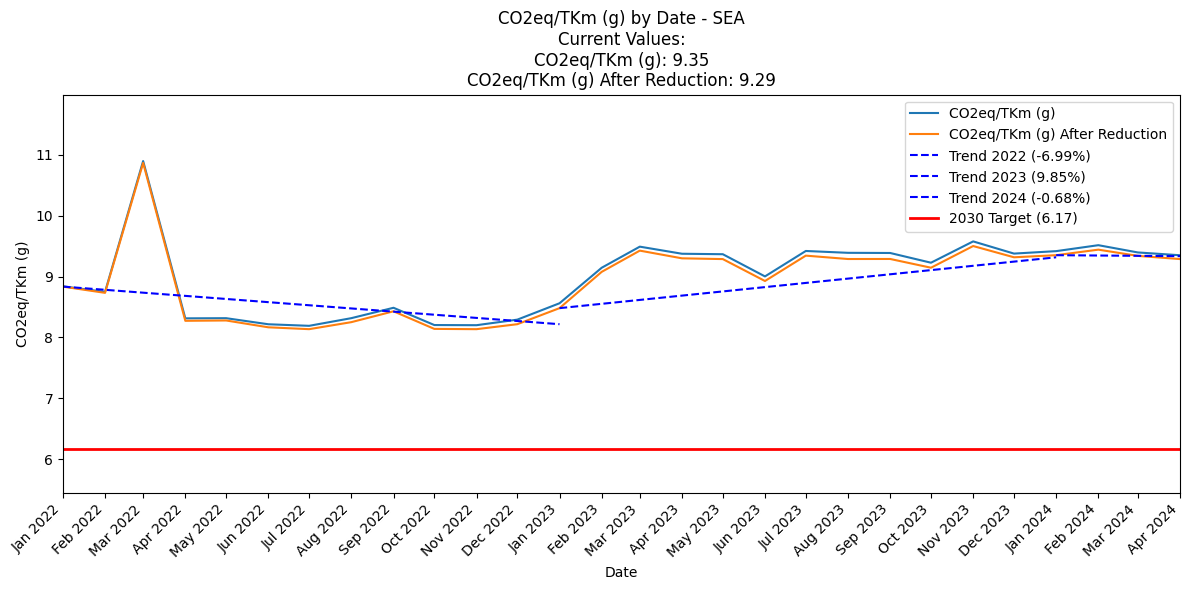

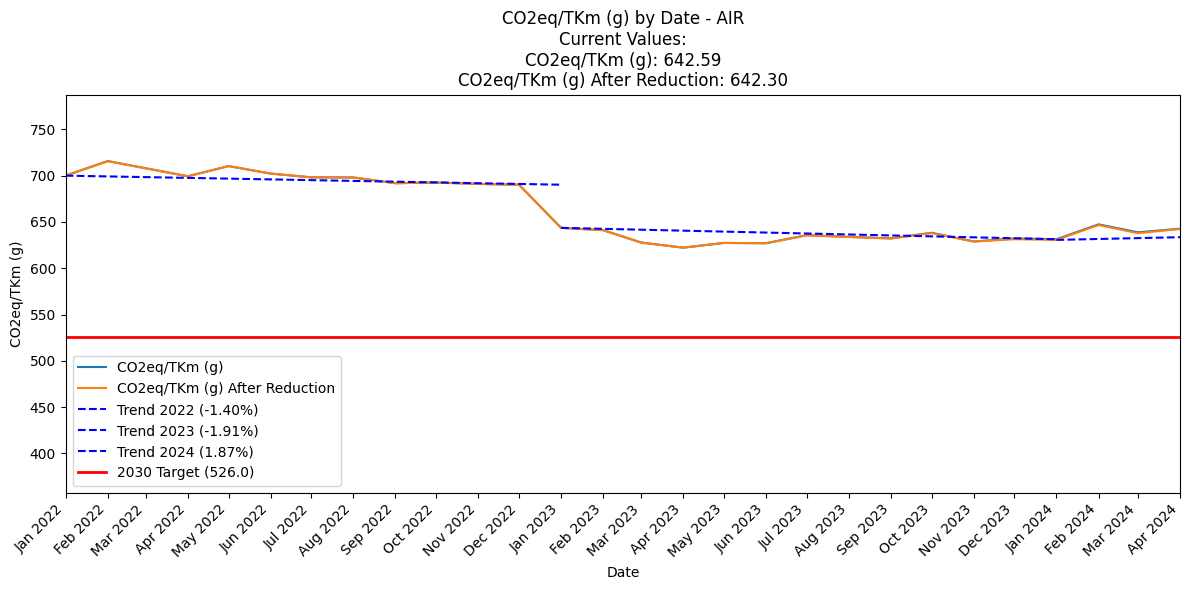

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

# Read the Excel file into a pandas DataFrame
df = pd.read_excel('100f177e-f178-43f9-8c65-5f0716ffd1bc.xlsx')

# Convert 'Service Completion Month' and 'Service Completion Year' to datetime
df['Date'] = pd.to_datetime(df['Service Completion Month'].str[:3] + ' ' + df['Service Completion Year'].astype(str), format='%b %Y')

# Define the transport modes and their corresponding 2030 targets
transport_modes = ['SEA', 'AIR']
targets = {'SEA': 6.17, 'AIR': 526.0}

# Define the columns to plot
columns_to_plot = ['CO2eq/TKm (g)', 'CO2eq/TKm (g) After Reduction']

for mode in transport_modes:
    # Filter the data for the current transport mode
    mode_data = df[df['Leg Transport Mode'] == mode]
    
    # Sort the data by date
    mode_data = mode_data.sort_values('Date')
    
    # Create a figure and subplot for the current transport mode
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for column in columns_to_plot:
        # Plot the line for the current transport mode and column
        ax.plot(mode_data['Date'], mode_data[column], label=column)
    
    # Calculate the maximum y-value across both columns
    max_value = mode_data[columns_to_plot].max().max()
    
    # Set the x-axis limits to start from January 2022
    start_date = datetime(2022, 1, 1)
    end_date = mode_data['Date'].max()
    ax.set_xlim(left=start_date, right=end_date)
    
    # Generate x-axis ticks for each month
    months = pd.date_range(start=start_date, end=end_date, freq='MS')
    ax.set_xticks(months)
    
    # Set the x-axis label and format
    ax.set_xlabel('Date')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    
    # Set the y-axis label
    ax.set_ylabel('CO2eq/TKm (g)')
    
    # Set the y-axis limits to 50% of the maximum value and add some space on top
    ax.set_ylim(bottom=max_value * 0.5, top=max_value * 1.1)
    
    # Get the unique years in the data
    years = mode_data['Date'].dt.year.unique()
    
    # Plot the trend line for each year and calculate the percentage change for 'CO2eq/TKm (g) After Reduction'
    for year in years:
        # Filter the data for the current year
        year_data = mode_data[(mode_data['Date'].dt.year == year)]
        
        # Get the start and end dates for the trend line
        start_date = datetime(year, 1, 1)
        end_date = datetime(year + 1, 1, 1)
        
        # Get the first and last values for the trend line
        start_value = year_data['CO2eq/TKm (g) After Reduction'].iloc[0]
        end_value = year_data['CO2eq/TKm (g) After Reduction'].iloc[-1]
        
        # Calculate the percentage change
        percentage_change = (end_value - start_value) / start_value * 100
        
        # Plot the trend line with the percentage change
        ax.plot([start_date, end_date], [start_value, end_value], linestyle='--', label=f'Trend {year} ({percentage_change:.2f}%)')
    
    # Draw a horizontal line at the 2030 target
    ax.axhline(targets[mode], color='red', linestyle='-', linewidth=2, label=f'2030 Target ({targets[mode]})')
    
    # Get the current values for both columns
    current_values = mode_data[columns_to_plot].iloc[-1]
    
    # Set the subplot title with the current values
    ax.set_title(f'CO2eq/TKm (g) by Date - {mode}\nCurrent Values:\n' + '\n'.join([f'{col}: {val:.2f}' for col, val in current_values.items()]))
    
    # Add a legend
    ax.legend()
    
    # Rotate the x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Save the plot as an individual picture
    plt.tight_layout()
    plt.savefig(f'{mode}_CO2eq_per_TKm_SF.png')
    
    # Display the plot
    plt.show()